# Deep Learning Assignment 3 - Part 2
### Latent Space Visualization

Student 1: Raneem Ibraheem + 212920896

Student 2: Aseel Nahhas + 212245096

# Imports

In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

# Preprocessing

In [3]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoder Class

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        # Fully connected layer to hidden dimension
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Fully connected layer to mean of latent space
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        # Fully connected layer to log variance of latent space
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        # Apply ReLU activation to the hidden layer
        h = torch.relu(self.fc1(x))
        # Compute the mean of the latent space
        mean = self.fc_mean(h)
        # Compute the log variance of the latent space
        log_var = self.fc_log_var(h)
        return mean, log_var

# Decoder Class

In [5]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(Decoder, self).__init__()
        # Fully connected layer from latent dimension to hidden dimension
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        # Fully connected layer from hidden dimension to output dimension
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Apply ReLU activation to the hidden layer
        h = torch.relu(self.fc1(x))
        # Apply Sigmoid activation to the output layer
        x_hat = torch.sigmoid(self.fc2(h))
        return x_hat

# Variational Auto Encoder Class

In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()
        # Initialize the encoder
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        # Initialize the decoder
        self.decoder = Decoder(input_dim, hidden_dim, latent_dim)
        
    def reparameterize(self, mean, log_var):
        # Reparameterization trick to sample from N(mean, var) from N(0,1)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        # Forward pass through the encoder
        mean, log_var = self.encoder(x)
        # Reparameterize to get the latent vector z
        z = self.reparameterize(mean, log_var)
        # Forward pass through the decoder
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [7]:
def expand_latent(z_2d, latent_dim=200):
    # Create a 200-dimensional tensor of zeros on the same device as z_2d
    z_full = torch.randn(latent_dim, device=z_2d.device)
    # Place the 2D latent values in the first two dimensions
    z_full[:2] = z_2d
    return z_full

In [8]:
# Initialize the VAE model and move it to the specified device
model = VAE().to(device)

# Set up the optimizer with Adam algorithm and learning rate of 1e-3
optimizer = Adam(model.parameters(), lr=1e-3)

# Loss Function Class


In [9]:
def loss_function(x, x_hat, mean, log_var):
    # Small constant to avoid division by zero
    eps = 1e-8
    # Binary Cross-Entropy loss
    BCE = -torch.sum(x * torch.log(x_hat + eps) + (1 - x) * torch.log(1 - x_hat + eps))
    # Kullback-Leibler Divergence
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - torch.exp(log_var))
    # Total loss is the sum of BCE and KLD
    return BCE + KLD

# Training Loop

In [10]:
def train(model, optimizer, epochs, device, x_dim=784):
    # Set the model to training mode
    model.train()  
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            # Reshape and move input to the device
            x = x.view(x.size(0), x_dim).to(device)  
            # Zero the gradients
            optimizer.zero_grad()  
            # Forward pass
            x_hat, mean, log_var = model(x)
            # Compute the loss  
            loss = loss_function(x, x_hat, mean, log_var)  
            overall_loss += loss.item()
            # Backward pass
            loss.backward()  
            # Update the weights
            optimizer.step()  

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/((batch_idx+1)*x.size(0)))
        
        if (epoch + 1) % 10 == 0:
            # Set the model to evaluation mode
            model.eval()  
            with torch.no_grad():
                # Create a 2D latent vector
                z_2d = torch.zeros(2).to(device)
                # Expand it to match the expected latent dimension
                z = expand_latent(z_2d, latent_dim=200)
                # Now decode the full latent vector
                sample = model.decoder(z).cpu().view(28, 28)
            # Plot the sample
            plt.imshow(sample, cmap='gray')
            plt.title(f"Sample reconstruction at epoch {epoch+1}")
            plt.axis('off')
            plt.show()
            # Set the model back to training mode
            model.train()
            
    # Return the overall loss
    return overall_loss

	Epoch 1 	Average Loss:  169.86888717447917
	Epoch 2 	Average Loss:  133.11363678385416
	Epoch 3 	Average Loss:  120.81466744791666
	Epoch 4 	Average Loss:  114.80801490885416
	Epoch 5 	Average Loss:  111.87681638997395
	Epoch 6 	Average Loss:  110.02584278971354
	Epoch 7 	Average Loss:  108.85941432291666
	Epoch 8 	Average Loss:  108.04025455729166
	Epoch 9 	Average Loss:  107.41294220377604
	Epoch 10 	Average Loss:  106.91996832682291


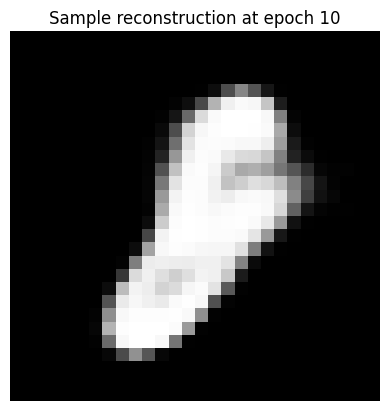

	Epoch 11 	Average Loss:  106.51587345377604
	Epoch 12 	Average Loss:  106.08102228190104
	Epoch 13 	Average Loss:  105.75174583333333
	Epoch 14 	Average Loss:  105.49855942382813
	Epoch 15 	Average Loss:  105.3194491048177
	Epoch 16 	Average Loss:  105.07061977539063
	Epoch 17 	Average Loss:  104.96239195963541
	Epoch 18 	Average Loss:  104.72237249348959
	Epoch 19 	Average Loss:  104.6060336751302
	Epoch 20 	Average Loss:  104.43282556966146


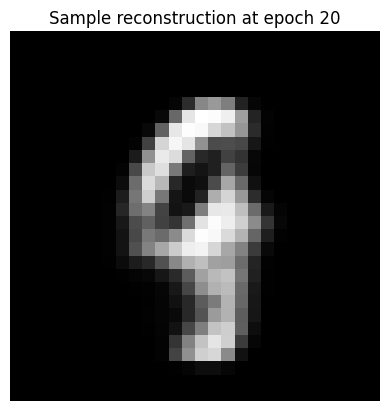

	Epoch 21 	Average Loss:  104.33312674153646
	Epoch 22 	Average Loss:  104.22235960286459
	Epoch 23 	Average Loss:  104.10610338541667
	Epoch 24 	Average Loss:  103.99478391927083
	Epoch 25 	Average Loss:  103.96696438802083
	Epoch 26 	Average Loss:  103.83841554361979
	Epoch 27 	Average Loss:  103.7933521484375
	Epoch 28 	Average Loss:  103.71601137695312
	Epoch 29 	Average Loss:  103.64285817057292
	Epoch 30 	Average Loss:  103.59159169921875


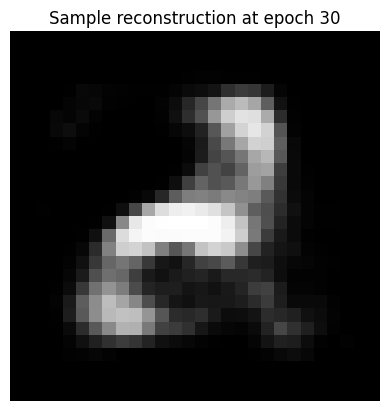

	Epoch 31 	Average Loss:  103.50223139648438
	Epoch 32 	Average Loss:  103.47981704101562
	Epoch 33 	Average Loss:  103.36537252604167
	Epoch 34 	Average Loss:  103.32206564127604
	Epoch 35 	Average Loss:  103.25074697265624
	Epoch 36 	Average Loss:  103.178346484375
	Epoch 37 	Average Loss:  103.16747034505208
	Epoch 38 	Average Loss:  103.11295120442708
	Epoch 39 	Average Loss:  103.0186010904948
	Epoch 40 	Average Loss:  102.99104147135417


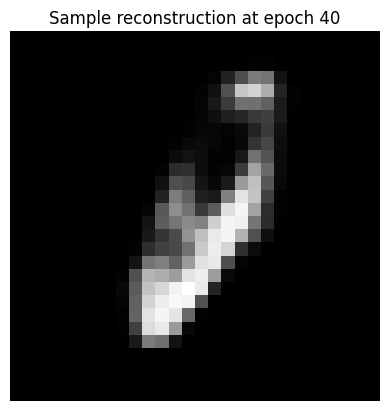

	Epoch 41 	Average Loss:  102.94185309244791
	Epoch 42 	Average Loss:  102.92672299804687
	Epoch 43 	Average Loss:  102.8332049967448
	Epoch 44 	Average Loss:  102.83357112630209
	Epoch 45 	Average Loss:  102.76281251627604
	Epoch 46 	Average Loss:  102.73279262695313
	Epoch 47 	Average Loss:  102.70680257161459
	Epoch 48 	Average Loss:  102.67583961588542
	Epoch 49 	Average Loss:  102.61797605794271
	Epoch 50 	Average Loss:  102.57243608398437


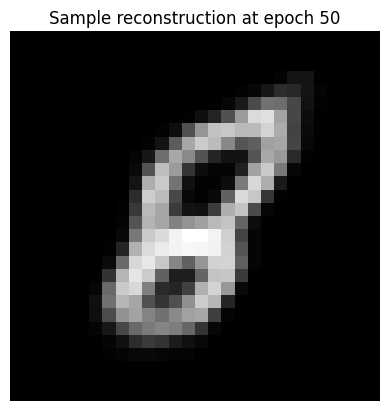

6154346.1650390625

In [11]:
# Train the model
train(model, optimizer, epochs=50, device=device)

# Generate and plot digit

In [12]:
def generate_digit(mean, var):
    # Create a 2D latent vector
    latent_2d = torch.tensor([mean, var]).to(device)
    # Expand it to the full latent dimension (200)
    latent = expand_latent(latent_2d, latent_dim=200)
    # Disable gradient computation for inference
    with torch.no_grad():
        # Set the model to evaluation mode to disable dropout and batch norm behaviors
        model.eval()
        # Pass the latent vector through the decoder to generate a digit, move result to CPU, and reshape to 28x28
        digit = model.decoder(latent).cpu().view(28, 28)
    # Define an inner function to plot the generated digit
    def plot_digit():
        # Display the generated digit as an image using a grayscale color map
        plt.imshow(digit, cmap="gray")
        # Set the plot title to indicate the latent vector used for generation
        plt.title(f"Generated digit with latent vector: [{mean}, {var}]")
        # Hide the axis for a cleaner display of the image
        plt.axis('off')
        # Render the plot
        plt.show()
    # Return the inner function so it can be called to display the generated digit
    return plot_digit

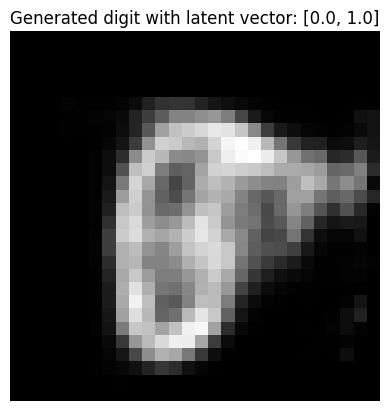

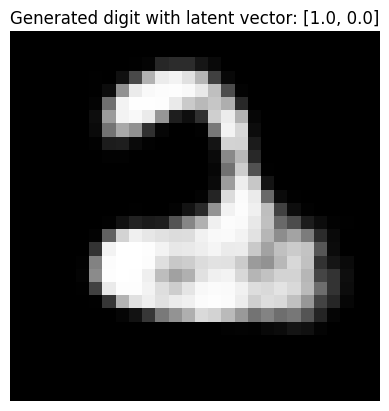

In [13]:
# Generate a plotting function for a digit using the latent vector [0.0, 1.0]
gen1 = generate_digit(0.0, 1.0)
# Generate a plotting function for a digit using the latent vector [1.0, 0.0]
gen2 = generate_digit(1.0, 0.0)
# Call the plotting function to display the digit generated from the latent vector [0.0, 1.0]
gen1()
# Call the plotting function to display the digit generated from the latent vector [1.0, 0.0]
gen2()

In [14]:
# Call generate_digit with latent vector [0.0, 1.0] to create a digit plotting function
# Call generate_digit with latent vector [1.0, 0.0] to create another digit plotting function
# This expression returns a tuple containing both of the digit plotting functions
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

(<function __main__.generate_digit.<locals>.plot_digit()>,
 <function __main__.generate_digit.<locals>.plot_digit()>)

# Latent Space Grid Visualization

In [15]:
# Define a function to visualize the latent space by decoding grid points into digit images
def plot_latent_space(model, scale, digit_size=28, figsize=15, grid_size=20):
    # Initialize a blank image (numpy array) to hold the grid of generated digits
    figure = np.zeros((digit_size * grid_size, digit_size * grid_size))
    # Create a grid of latent x-values ranging from -scale to scale with grid_size points
    grid_x = np.linspace(-scale, scale, grid_size)
    # Create a grid of latent y-values, reverse the order for proper visualization
    grid_y = np.linspace(-scale, scale, grid_size)[::-1]
    
    # Disable gradient computations for inference
    with torch.no_grad():
        # Set the model to evaluation mode (disables dropout, batchnorm, etc.)
        model.eval()
        # Loop over each y-value in the latent grid
        for i, yi in enumerate(grid_y):
            # Loop over each x-value in the latent grid
            for j, xi in enumerate(grid_x):
                # Create a 2D latent vector from the grid point
                z_2d = torch.tensor([xi, yi], dtype=torch.float32).to(device)
                # Expand the 2D latent vector to the full latent dimension (200)
                z = expand_latent(z_2d, latent_dim=200)
                # Decode the full latent vector to generate an image, then process it
                x_hat = model.decoder(z).cpu().numpy()
                digit = x_hat.reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                    j * digit_size: (j + 1) * digit_size] = digit

    # Create a new matplotlib figure with the specified size
    plt.figure(figsize=(figsize, figsize))
    # Calculate the starting pixel position for tick marks (center of the first digit image)
    start_range = digit_size // 2
    # Calculate the ending pixel position based on the grid size and digit size
    end_range = grid_size * digit_size + start_range
    # Generate an array of pixel positions for tick marks along each axis
    pixel_range = np.arange(start_range, end_range, digit_size)
    # Round the x-axis latent values for tick labels to one decimal place
    sample_range_x = np.round(grid_x, 1)
    # Round the y-axis latent values for tick labels to one decimal place
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="gray")
    plt.title("Latent Space Visualization")
    plt.show()

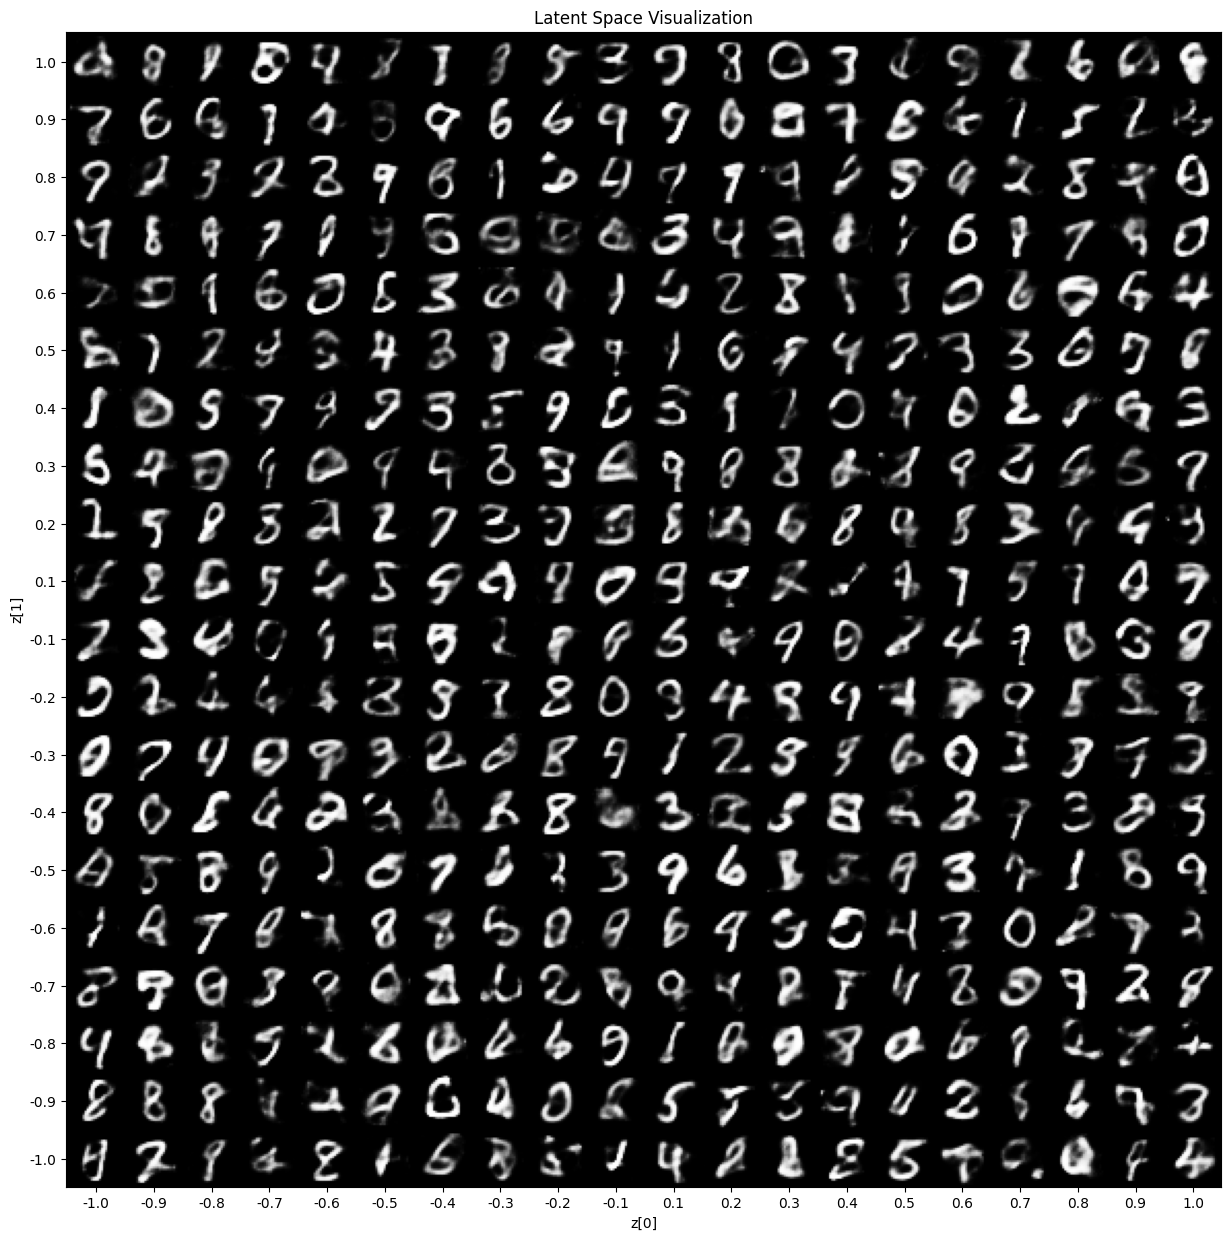

In [16]:
# Call the function to plot the latent space visualization of the model
# Here, 'model' is the trained VAE, and scale=1.0 sets the range of latent variables from -1.0 to 1.0.
plot_latent_space(model, scale=1.0)

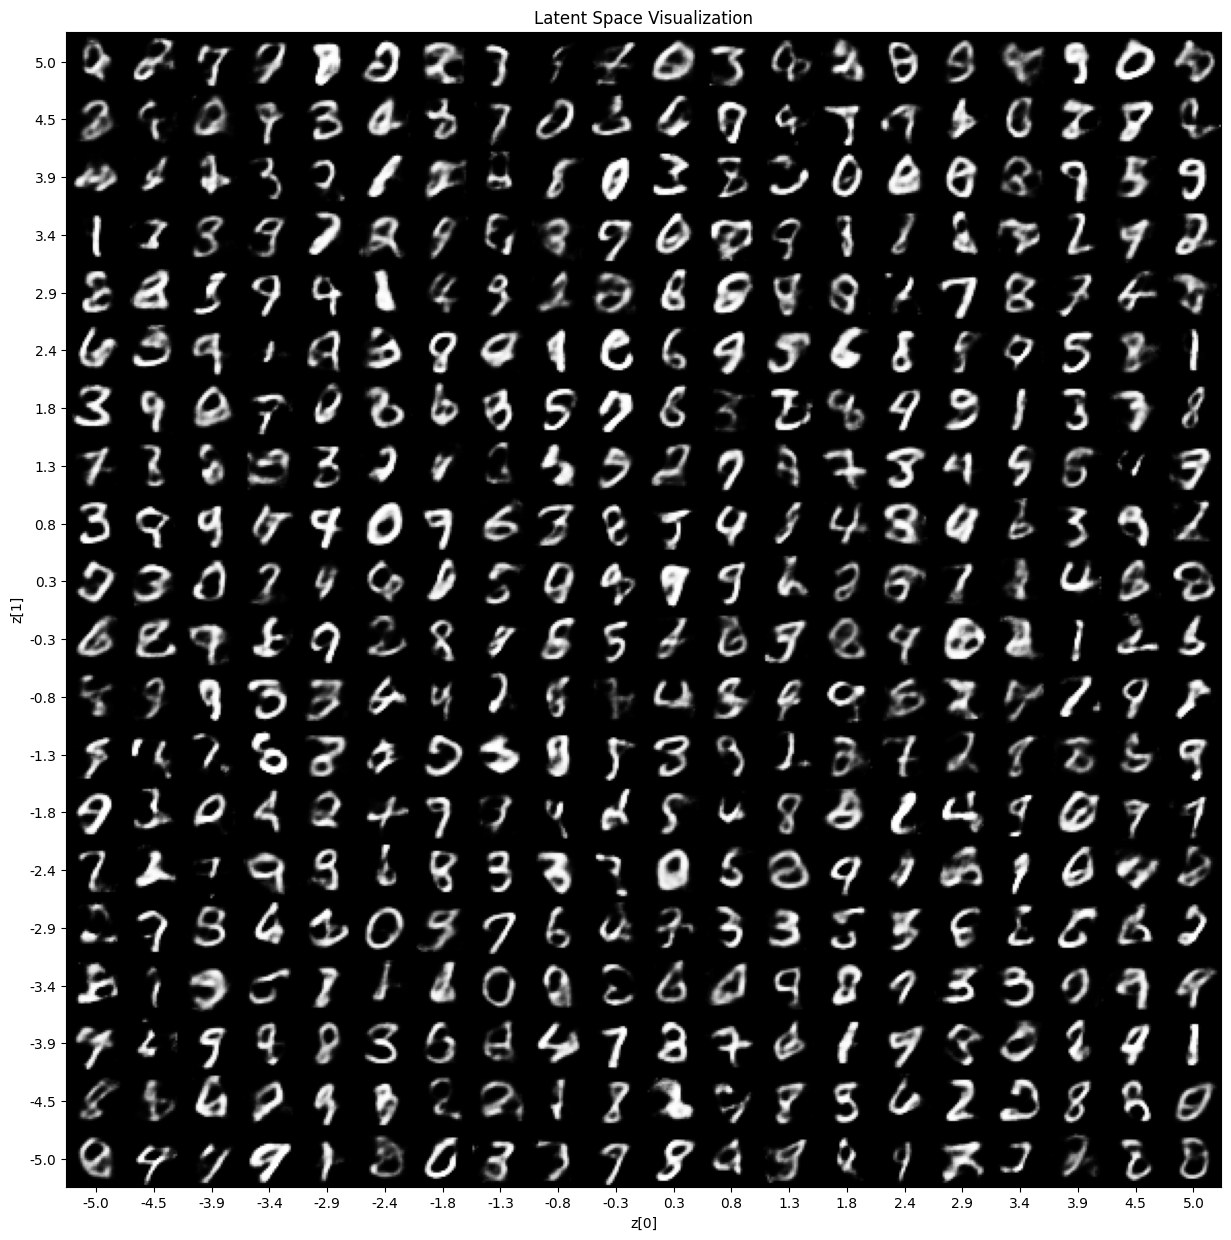

In [17]:
# Call the function to plot the latent space visualization of the model
# Here, 'model' is the trained VAE, and scale=5.0 sets the range of latent variables from -5.0 to 5.0.
plot_latent_space(model, scale=5.0)

# Linear Interpolation

In [18]:
def linear_interpolation(model, num_steps=10):
    # Create an iterator over the test loader to get a batch of test images and labels
    test_loader_iter = iter(test_loader)
    # Retrieve one batch of images and corresponding labels
    images, labels = next(test_loader_iter)
    # Convert the labels tensor to a NumPy array for easier manipulation
    labels_np = labels.numpy()
    # Determine the unique labels present in this batch
    unique_labels = np.unique(labels_np)
    
    # Randomly select two distinct labels from the unique labels
    l1, l2 = np.random.choice(unique_labels, size=2, replace=False)
    # Find the index of the first occurrence of label l1
    idx1 = (labels == l1).nonzero()[0].item()
    # Find the index of the first occurrence of label l2
    idx2 = (labels == l2).nonzero()[0].item()
    
    # Select the image corresponding to label l1, flatten it to a 784-dimensional vector, and move it to the device
    img1 = images[idx1].view(-1, 784).to(device)
    # Select the image corresponding to label l2, flatten it to a 784-dimensional vector, and move it to the device
    img2 = images[idx2].view(-1, 784).to(device)
    
    # Disable gradient calculations for the following operations (inference mode)
    with torch.no_grad():
        # Set the model to evaluation mode (affects layers like dropout or batchnorm)
        model.eval()
        # Encode the first image to obtain its latent space parameters (mean and log variance)
        mean1, log_var1 = model.encoder(img1)
        # Sample a latent vector z1 using the reparameterization trick
        z1 = model.reparameterize(mean1, log_var1)
        # Encode the second image to obtain its latent space parameters (mean and log variance)
        mean2, log_var2 = model.encoder(img2)
        # Sample a latent vector z2 using the reparameterization trick
        z2 = model.reparameterize(mean2, log_var2)
    
    # Initialize an empty list to store the interpolated images
    interpolation = []
    # Iterate over a sequence of interpolation factors between 0 and 1 (inclusive)
    for t in np.linspace(0, 1, num_steps):
        # Compute the interpolated latent vector as a linear combination of z1 and z2
        z = (1 - t) * z1 + t * z2
        # Decode the latent vector into an image, remove gradients, move to CPU, reshape to 28x28, and convert to NumPy array
        x_hat = model.decoder(z).detach().cpu().view(28, 28).numpy()
        # Append the generated image to the interpolation list
        interpolation.append(x_hat)
    
    # Create a figure with a row of subplots (one for each interpolation step)
    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps, 2))
    # Loop over each subplot and display the corresponding interpolated image
    for i, ax in enumerate(axes):
        # Display the image using a grayscale colormap
        ax.imshow(interpolation[i], cmap="gray")
        # Remove axis ticks and labels for clarity
        ax.axis('off')
        # Set a title for the subplot indicating the interpolation factor (from 0.00 to 1.00)
        ax.set_title(f"{(i/(num_steps-1)):.2f}")
    # Set an overall title for the figure indicating the two digits being interpolated
    plt.suptitle(f"Linear Interpolation between digits {l1} and {l2}")
    # Render the figure
    plt.show()

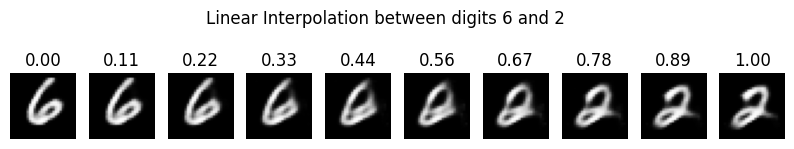

In [19]:
linear_interpolation(model, num_steps=10)

In [20]:
from torchsummary import summary
# Print the model summary and the parameters
summary(model, input_size=(784,), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         314,000
            Linear-2                  [-1, 200]          80,200
            Linear-3                  [-1, 200]          80,200
           Encoder-4     [[-1, 200], [-1, 200]]               0
            Linear-5                  [-1, 400]          80,400
            Linear-6                  [-1, 784]         314,384
           Decoder-7                  [-1, 784]               0
Total params: 869,184
Trainable params: 869,184
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.28
Params size (MB): 3.32
Estimated Total Size (MB): 3.60
----------------------------------------------------------------
